### Data Preprocess with all Data

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#dir path
data_path = "data/s001_force"  
print("Current working directory:", os.getcwd())

file_list = [f for f in os.listdir(data_path) if f.endswith(".npy")]

cop_all, grf_all = [], []

# Loop through files to preprocess
for file_name in file_list:
    file_path = os.path.join(data_path, file_name)
    data_force = np.load(file_path, allow_pickle=True).item()

    # tensors -> numpy arrays
    cop_data = data_force['CoP'].numpy()
    grf_data = data_force['GRF'].numpy()

    # flatten to x and y to match input from video
    cop_2d = cop_data[:, :, :2]  
    grf_2d = grf_data[:, :, :2]  


    df_cop = pd.DataFrame(cop_2d.reshape(cop_2d.shape[0], -1), columns=[
        'CoP_L_X', 'CoP_L_Y', 'CoP_R_X', 'CoP_R_Y'
    ])
    df_grf = pd.DataFrame(grf_2d.reshape(grf_2d.shape[0], -1), columns=[
        'GRF_L_X', 'GRF_L_Y', 'GRF_R_X', 'GRF_R_Y'
    ])


    framerate = 100 

    # vel computation
    df_cop['CoP_L_vX'] = df_cop['CoP_L_X'].diff() * framerate
    df_cop['CoP_L_vY'] = df_cop['CoP_L_Y'].diff() * framerate
    df_cop['CoP_R_vX'] = df_cop['CoP_R_X'].diff() * framerate
    df_cop['CoP_R_vY'] = df_cop['CoP_R_Y'].diff() * framerate

    # accel computation
    df_cop['CoP_L_aX'] = df_cop['CoP_L_vX'].diff() * framerate
    df_cop['CoP_L_aY'] = df_cop['CoP_L_vY'].diff() * framerate
    df_cop['CoP_R_aX'] = df_cop['CoP_R_vX'].diff() * framerate
    df_cop['CoP_R_aY'] = df_cop['CoP_R_vY'].diff() * framerate

    # Drop nan from derivitaves 
    df_cop.dropna(inplace=True)
    df_grf = df_grf.iloc[2:].reset_index(drop=True)  


    cop_all.append(df_cop)
    grf_all.append(df_grf)

Current working directory: /Users/Bianca/Documents/iCloud Drive/Documents/Bianca/CS/Projects/2025/2_25/strAIn/models


In [ ]:

df_cop_all = pd.concat(cop_all, ignore_index=True)
df_grf_all = pd.concat(grf_all, ignore_index=True)

print("Final Processed CoP Shape:", df_cop_all.shape)
print("Final Processed GRF Shape:", df_grf_all.shape)

# Combine data sets together
df_cop_all.to_csv("processed_cop_data_all.csv", index=False)
df_grf_all.to_csv("processed_grf_data_all.csv", index=False)


Final Processed CoP Shape: (229612, 12)
Final Processed GRF Shape: (229612, 4)


### XBG (Extreme Gradient Boosted Trees)

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Train 
# Features: CoP, vel, accel (all x and y)
# Targets: GRF (Ground Reaction Force) pred in x, y
X = df_cop_all.values  
y = df_grf_all.values  

# Sequentially split 
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Train Set Size:", len(X_train))
print("Test Set Size:", len(X_test))

xgb_model = xgb.XGBRegressor(
    n_estimators=200,    
    learning_rate=0.05,  
    max_depth=6,         
    subsample=0.8,       
    colsample_bytree=0.8, 
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predictions + Eval
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("XGBoost Mean Squared Error:", mse_xgb)


Train Set Size: 183689
Test Set Size: 45923
XGBoost Mean Squared Error: 0.0012595303123816848


### Visualization

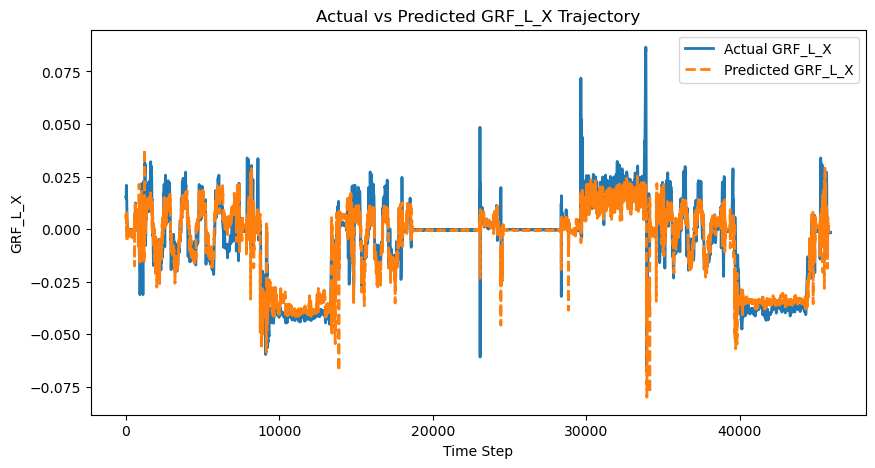

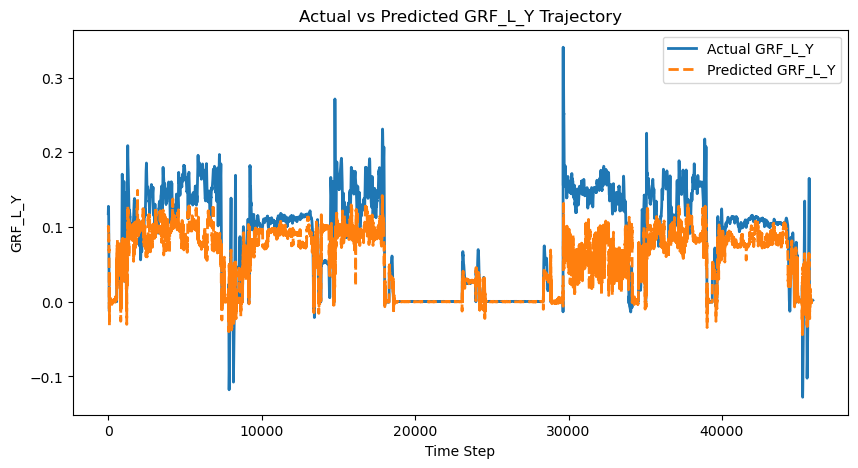

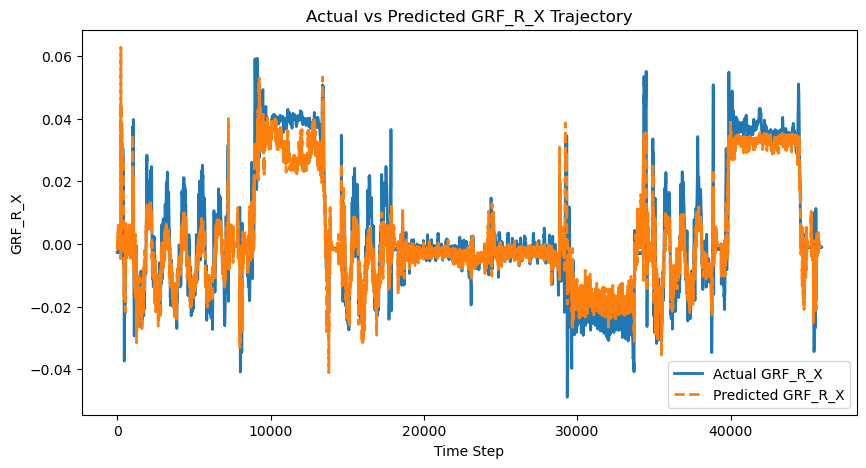

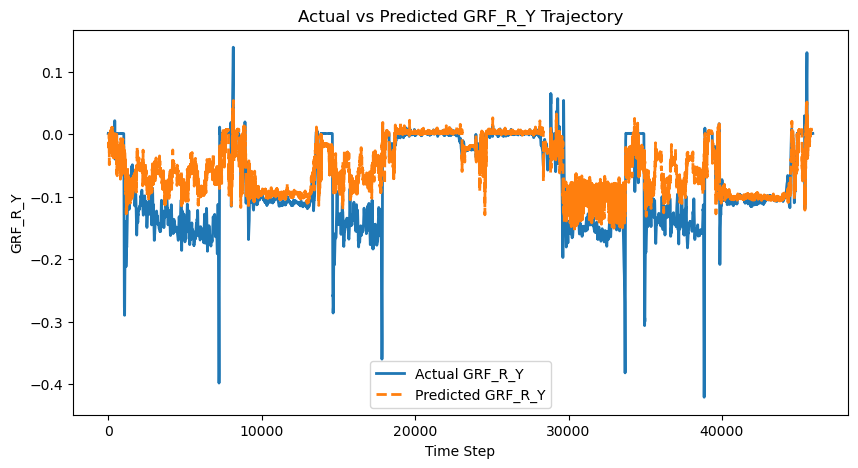

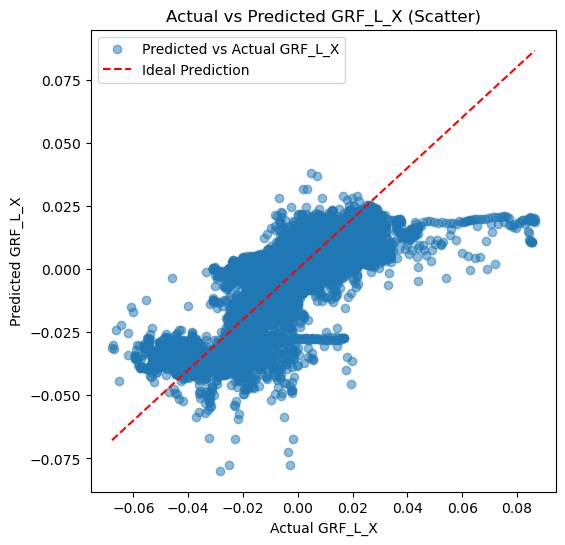

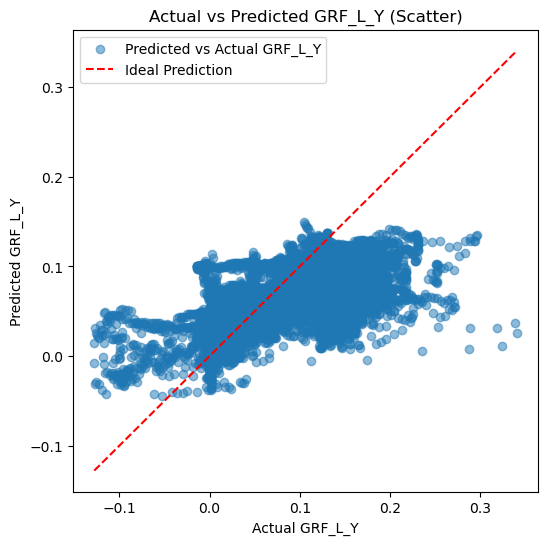

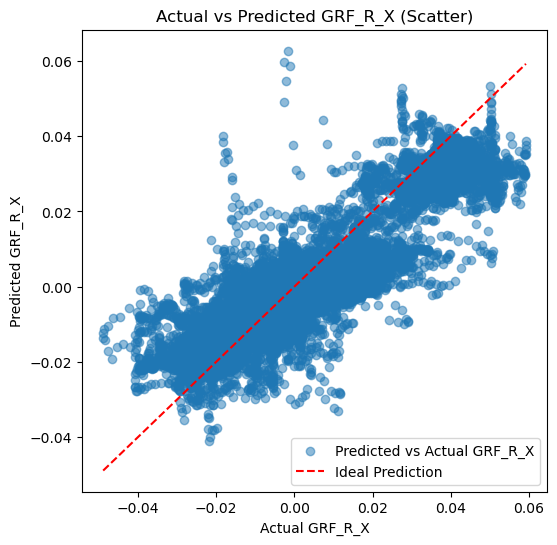

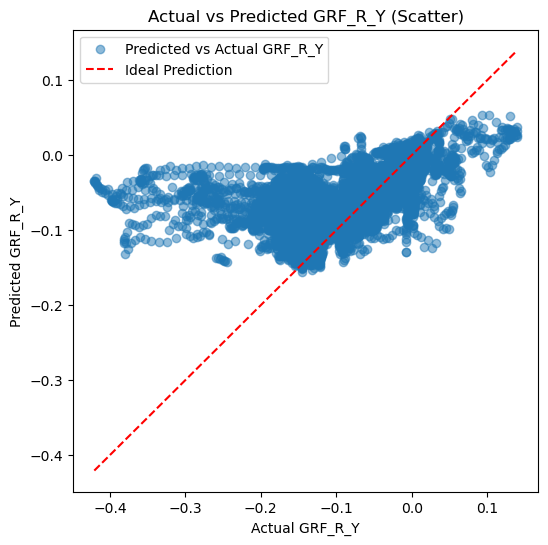

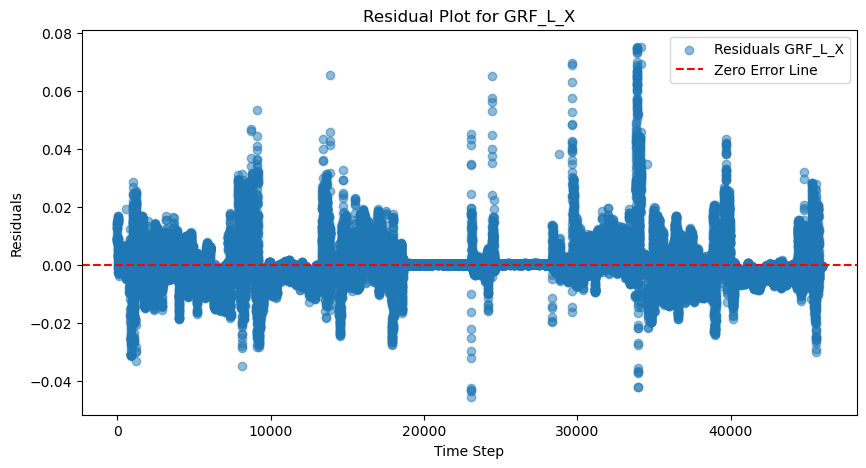

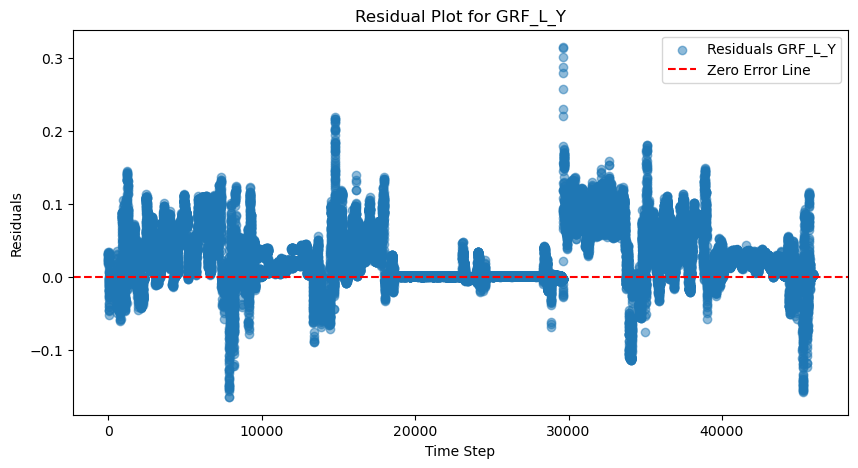

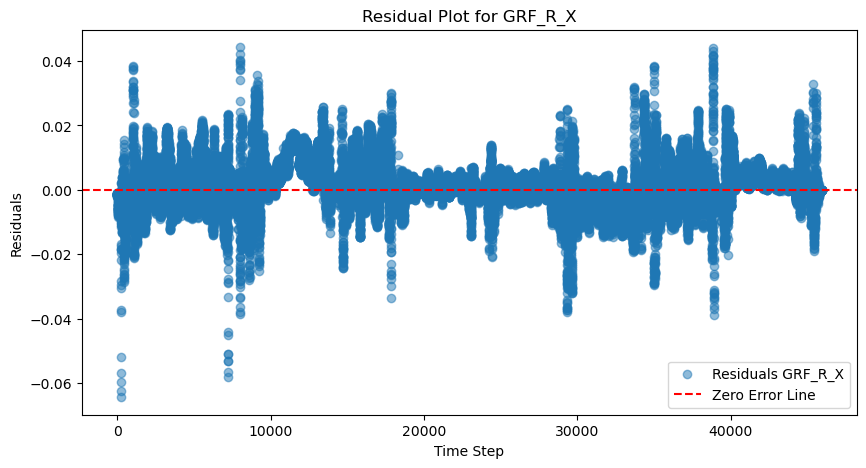

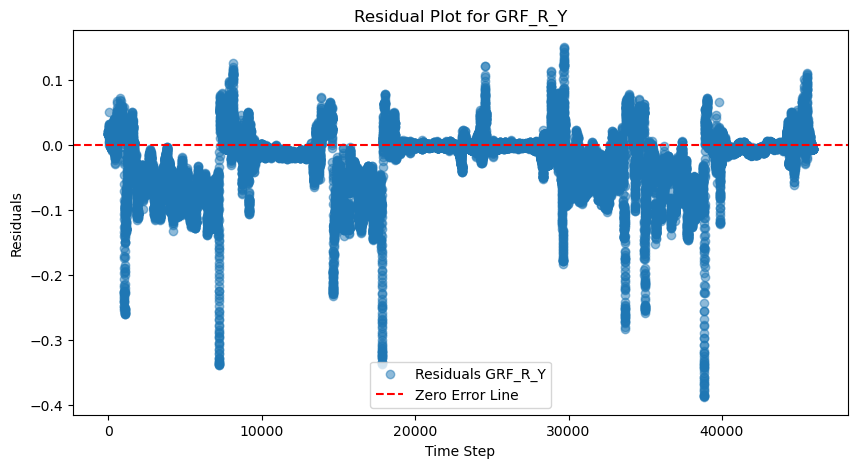

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_test_np = y_test
y_test_pred_np = y_pred_xgb

# Define axes 
time_steps = np.arange(len(y_test_np))
grf_labels = ['GRF_L_X', 'GRF_L_Y', 'GRF_R_X', 'GRF_R_Y']

# Graph 1:
# Actual vs. Pred GRF Trajectories 
for i, label in enumerate(grf_labels):
    plt.figure(figsize=(10, 5))
    plt.plot(time_steps, y_test_np[:, i], label=f"Actual {label}", linestyle="-", linewidth=2)
    plt.plot(time_steps, y_test_pred_np[:, i], label=f"Predicted {label}", linestyle="--", linewidth=2)
    plt.xlabel("Time Step")
    plt.ylabel(label)
    plt.title(f"Actual vs Predicted {label} Trajectory")
    plt.legend()
    plt.show()

# Graph 2:
# Scatter Plots of Actual vs. Pred GRF
for i, label in enumerate(grf_labels):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_np[:, i], y_test_pred_np[:, i], alpha=0.5, label=f"Predicted vs Actual {label}")
    plt.plot([min(y_test_np[:, i]), max(y_test_np[:, i])], 
             [min(y_test_np[:, i]), max(y_test_np[:, i])], 
             color='red', linestyle='dashed', label='Ideal Prediction')
    plt.xlabel(f"Actual {label}")
    plt.ylabel(f"Predicted {label}")
    plt.title(f"Actual vs Predicted {label} (Scatter)")
    plt.legend()
    plt.show()

# Graph 3:
# Residual Plots Analysis)
for i, label in enumerate(grf_labels):
    residuals = y_test_np[:, i] - y_test_pred_np[:, i]
    
    plt.figure(figsize=(10, 5))
    plt.scatter(time_steps, residuals, alpha=0.5, label=f"Residuals {label}")
    plt.axhline(y=0, color='red', linestyle='dashed', label="Zero Error Line")
    plt.xlabel("Time Step")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {label}")
    plt.legend()
    plt.show()


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Compute regression metrics
mse = mean_squared_error(y_test_np, y_test_pred_np)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, y_test_pred_np)
r2 = r2_score(y_test_np, y_test_pred_np)

# Print results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 0.0013
Root Mean Squared Error (RMSE): 0.0355
Mean Absolute Error (MAE): 0.0190
R² Score: 0.6578


In [9]:
import joblib

# Save the trained model
joblib.dump(xgb_model, "xgb_prediction_model.pkl")

print("Model saved successfully!")


Model saved successfully!
